<a href="https://colab.research.google.com/github/brianmulyadi/Designing-Data-Products/blob/main/pass_bill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Start by connecting gdrive into the google colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from datetime import datetime
from datetime import date

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('drive/MyDrive/congress.csv', parse_dates=True, index_col=0, header=0)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13734 entries, 0 to 13733
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   policyArea         13666 non-null  object 
 1   issponsorPartyMaj  13734 non-null  int64  
 2   cosponsors         13734 non-null  int64  
 3   cosponsorsMaj      13734 non-null  float64
 4   billStatus         13734 non-null  int64  
 5   leadershipRole     13734 non-null  int64  
 6   dwNominate         13734 non-null  float64
 7   seniority          13734 non-null  int64  
 8   votesAgainstParty  13734 non-null  float64
dtypes: float64(3), int64(5), object(1)
memory usage: 1.0+ MB


In [5]:
df.describe()

,issponsorPartyMaj,cosponsors,cosponsorsMaj,billStatus,leadershipRole,dwNominate,seniority,votesAgainstParty
count,13734.000000,13734.000000,1.373400e+04,13734.000000,13734.000000,13734.000000,13734.000000,13734.000000
mean,0.564948,16.565604,inf,0.101864,0.184651,0.011433,11.692879,4.588020
std,0.495782,35.382814,NaN,0.302480,0.388028,0.422774,9.469818,4.858642
min,0.000000,0.000000,-1.000000e+00,0.000000,0.000000,-0.702000,2.000000,0.000000
25%,0.000000,1.000000,0.000000e+00,0.000000,0.000000,-0.386000,4.000000,1.630000
50%,1.000000,4.000000,5.184566e-01,0.000000,0.000000,0.000000,8.000000,3.260000
75%,1.000000,16.000000,1.000000e+00,0.000000,0.000000,0.432000,16.000000,5.410000
max,1.000000,385.000000,inf,1.000000,1.000000,0.931000,54.000000,38.730000


In [6]:
# sns.countplot(x=raw_data['billStatus'])
# sns.countplot(y=raw_data['policyArea'], order = raw_data['policyArea'].value_counts().index)

In [7]:
# create dummy variables for policy area
df['policyArea'] = df['policyArea'].fillna('Other')
df = pd.get_dummies(df,columns=['policyArea'])
df.head()

,issponsorPartyMaj,cosponsors,cosponsorsMaj,billStatus,leadershipRole,dwNominate,seniority,votesAgainstParty,policyArea_Agriculture and Food,policyArea_Animals,...,policyArea_Other,policyArea_Private Legislation,policyArea_Public Lands and Natural Resources,"policyArea_Science, Technology, Communications",policyArea_Social Sciences and History,policyArea_Social Welfare,policyArea_Sports and Recreation,policyArea_Taxation,policyArea_Transportation and Public Works,policyArea_Water Resources Development
0,1,24,1.000000,1,0,0.518,22,1.47,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,1.000000,1,0,0.590,14,4.74,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,16,1.000000,1,1,0.462,12,1.43,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,15,0.533333,1,1,0.374,18,3.49,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,25,0.960000,1,1,0.496,26,1.95,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# get list of feature columns
featureDf= df.loc[:, ~df.columns.isin(['billStatus'])]
featureDf.head()
feature_cols = featureDf.columns.values.tolist()
del featureDf
print(feature_cols)

['issponsorPartyMaj', 'cosponsors', 'cosponsorsMaj', 'leadershipRole', 'dwNominate', 'seniority', 'votesAgainstParty', 'policyArea_Agriculture and Food', 'policyArea_Animals', 'policyArea_Armed Forces and National Security', 'policyArea_Arts, Culture, Religion', 'policyArea_Civil Rights and Liberties, Minority Issues', 'policyArea_Commerce', 'policyArea_Congress', 'policyArea_Crime and Law Enforcement', 'policyArea_Economics and Public Finance', 'policyArea_Education', 'policyArea_Emergency Management', 'policyArea_Energy', 'policyArea_Environmental Protection', 'policyArea_Families', 'policyArea_Finance and Financial Sector', 'policyArea_Foreign Trade and International Finance', 'policyArea_Government Operations and Politics', 'policyArea_Health', 'policyArea_Housing and Community Development', 'policyArea_Immigration', 'policyArea_International Affairs', 'policyArea_Labor and Employment', 'policyArea_Law', 'policyArea_Native Americans', 'policyArea_Other', 'policyArea_Private Legisla

In [10]:
# replace NaN and inf in the dataset
df['billStatus'] = df['billStatus'].fillna(0)
df['billStatus'].replace([np.inf, -np.inf], 0, inplace = True)
df['cosponsorsMaj'].replace(np.inf, 0, inplace = True)


In [11]:
# check which row has infinite numbers
# x = 0
# for row in np.isfinite(df['cosponsorsDem']):
#   x += 1
#   if row == False:
#     print(x)

In [12]:
# output to file for dataset check before running models
# df.to_csv("/for_test.csv")

In [13]:
# feature_cols = ['issponsorPartyD','cosponsors','cosponsorsDem','cosponsorsRep','leadershipRole','dwNominate','seniority']
from sklearn.model_selection import train_test_split

x = df[feature_cols]
y = df.billStatus

# split into train-test data

x_train, x_test, y_train, y_test = train_test_split(x,y, 
                                   test_size=0.25, 
                                   shuffle=True)

In [15]:
# get a rough idea of train test proportion
print(y_train.sum())
print(y_train.count())
print("Ratio of passed bills in training set:", round(y_train.sum()/y_train.count(),3))
print(y_test.sum())
print(y_test.count())
print("Ratio of passed bills in test set:", round(y_train.sum()/y_train.count(),3))

1023
10300
Ratio of passed bills in training set: 0.099
376
3434
Ratio of passed bills in test set: 0.099


# Logistic Regression

In [16]:
log = LogisticRegression(max_iter=1500)
log.fit(x_train, y_train)
y_pred = log.predict(x_test)

In [17]:
def printMetrics(y_test, y_pred):
  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
  print("Recall:",metrics.recall_score(y_test,y_pred))
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))

printMetrics(y_test, y_pred)

Accuracy: 0.8907979033197437
Recall: 0.007978723404255319
[[3056    2]
 [ 373    3]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      3058
           1       0.60      0.01      0.02       376

    accuracy                           0.89      3434
   macro avg       0.75      0.50      0.48      3434
weighted avg       0.86      0.89      0.84      3434



In [18]:
auc = metrics.roc_auc_score(y_test, y_pred)
print(auc)

0.5036623505837498


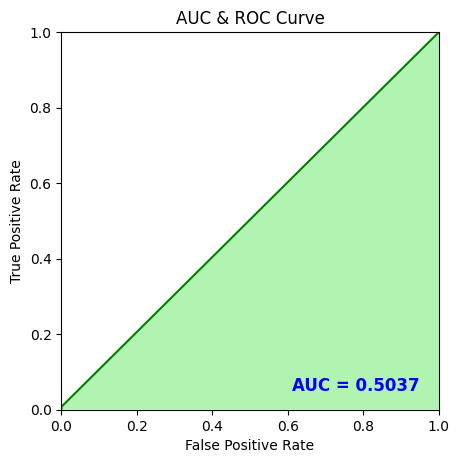

In [19]:
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Decision Tree

In [20]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

In [21]:
printMetrics(y_test, y_pred)
print("Max Depth:",clf.tree_.max_depth)
print("Node Count:",clf.tree_.node_count)

Accuracy: 0.8465346534653465
Recall: 0.29521276595744683
[[2796  262]
 [ 265  111]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3058
           1       0.30      0.30      0.30       376

    accuracy                           0.85      3434
   macro avg       0.61      0.60      0.61      3434
weighted avg       0.85      0.85      0.85      3434

Max Depth: 37
Node Count: 2497


In [22]:
auc = metrics.roc_auc_score(y_test, y_pred)
print(auc)

0.6047679264712021


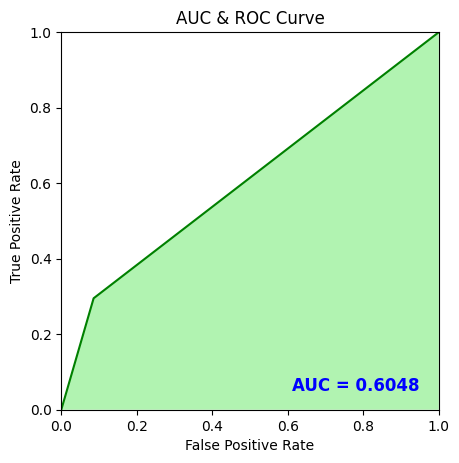

In [23]:
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Random Forest

In [24]:
forest = RandomForestClassifier(n_estimators = 10)
forest.fit(x_train, y_train)
y_pred = forest.predict(x_test)

In [25]:
printMetrics(y_test, y_pred)

Accuracy: 0.890215492137449
Recall: 0.15159574468085107
[[3000   58]
 [ 319   57]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3058
           1       0.50      0.15      0.23       376

    accuracy                           0.89      3434
   macro avg       0.70      0.57      0.59      3434
weighted avg       0.86      0.89      0.86      3434



In [26]:
auc = metrics.roc_auc_score(y_test, y_pred)
print(auc)

0.5663145499074629


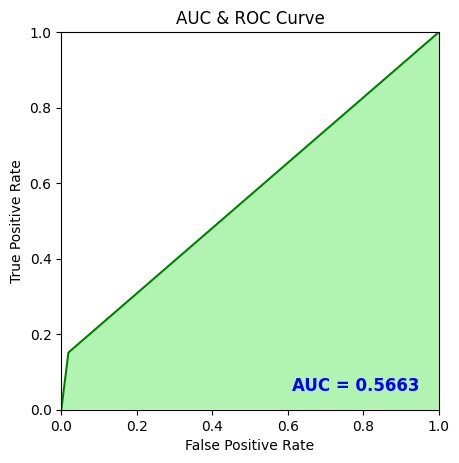

In [27]:
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [28]:
# using graphviz
# import graphviz

# dot_data = tree.export_graphviz(clf, out_file=None)
# graph = graphviz.Source(dot_data)
# graph

In [29]:
# plt.figure(figsize=(10,10))
# a = plot_tree(clf, 
#               feature_names=feature_cols, 
#               class_names=True, 
#               filled=True, 
#               rounded=True, 
#               fontsize=14)